In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import tarfile
from pathlib import Path

data_path = Path('cifar-10-batches-py/')
filename = "cifar-10-python.tar.gz"

if data_path.is_dir():
  print(f"{filename} directory exists.")
else:
  url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

  print("Downloading CIFAR-10...")
  response = requests.get(url, stream=True)
  with open(filename, "wb") as f:
      for chunk in response.iter_content(chunk_size=1024):
          if chunk:
              f.write(chunk)
  print("Download complete.")

  print("Extracting...")
  with tarfile.open(filename, "r:gz") as tar:
      tar.extractall()
  print("Extraction complete.")


Download complete.
Extracting...
Extraction complete.


In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.CIFAR10(
    root="./",
    train=True,
    transform=train_transform,
    download=False
)

test_dataset = datasets.CIFAR10(
    root="./",
    download=False,
    train=False,
    transform=test_transform
)

len(train_dataset), len(test_dataset)

(50000, 10000)

In [6]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(1563, 313)

In [7]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
classes

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

In [8]:
# Check the shape of a batch in dataloader
data_batch, labels_batch = next(iter(train_dataloader))
data_batch.shape, labels_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

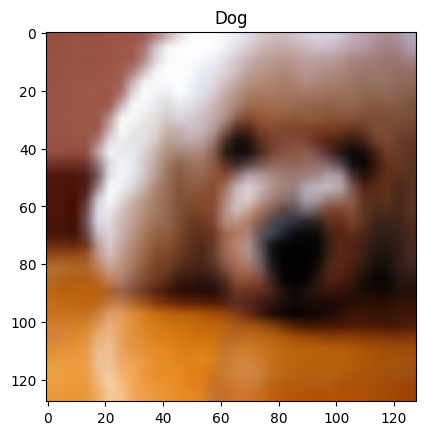

In [9]:
first_image = data_batch[0].permute(1,2,0)

plt.imshow(first_image)
plt.title(classes[labels_batch[0]])
plt.show()

In [10]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in tqdm(enumerate(dataloader)):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_classes==y).sum().item() / len(y_pred)

  train_loss /= len(dataloader)
  train_loss /= len(dataloader)
  return train_loss, train_acc


In [11]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels==y).sum().item() / len(test_pred_labels)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [15]:
def train(epochs: int,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          model: torch.nn.Module,
          device: torch.device,
          loss_fn: torch.nn.Module):
  model_train_results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):

    print(f"Epoch: {epoch+1} \n")

    train_loss, train_acc = train_step(model=model, loss_fn=loss_fn,
                                       dataloader=train_dataloader,
                                       device=device, optimizer=optimizer)

    test_loss, test_acc = test_step(model=model, loss_fn=loss_fn,
                                    dataloader=test_dataloader,
                                    device=device,
                                    optimizer=optimizer)

    print(f"Train loss: {train_loss:.4f} , Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}% \n\n")

    model_train_results["train_loss"].append(train_loss)
    model_train_results["train_acc"].append(train_acc)
    model_train_results["test_loss"].append(test_loss)
    model_train_results["test_acc"].append(test_loss)

  return model_train_results



In [16]:
from torch import nn

class ConvolutionalTrainer(nn.Module):
  def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
    super().__init__()

    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  padding=1,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_shape,
                  out_channels=hidden_shape,
                  padding=1,
                  stride=1,
                  kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_shape*32*32,
                  output_shape)
    )

  def forward(self, x):
    x = self.layer_1(x)
    # print(x.shape)
    x = self.layer_2(x)
    # print(x.shape)
    x = self.classifier_layer(x)

    return x


model_CNN = ConvolutionalTrainer(input_shape=3,
                                 hidden_shape=10,
                                 output_shape=len(classes)).to(device)
model_CNN

ConvolutionalTrainer(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=10, bias=True)
  )
)

In [17]:
from timeit import default_timer as Timer
start_timer = Timer()

EPOCHS = 5

train_result = train(model=model_CNN,
      device=device,
      epochs=EPOCHS,
      loss_fn=nn.CrossEntropyLoss(),
      optimizer=torch.optim.Adam(params=model_CNN.parameters(), lr=0.001),
      test_dataloader=test_dataloader,
      train_dataloader=train_dataloader)

end_timer = Timer()
print(f"Total time of training: {end_timer-start_timer} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 



0it [00:00, ?it/s]

Train loss: 0.0011 , Train acc: 596.44% | Test loss: 1.4914, Test acc: 0.47% 


Epoch: 2 



0it [00:00, ?it/s]

Train loss: 0.0009 , Train acc: 768.94% | Test loss: 1.3311, Test acc: 0.53% 


Epoch: 3 



0it [00:00, ?it/s]

Train loss: 0.0008 , Train acc: 835.78% | Test loss: 1.2811, Test acc: 0.54% 


Epoch: 4 



0it [00:00, ?it/s]

Train loss: 0.0008 , Train acc: 895.34% | Test loss: 1.1813, Test acc: 0.58% 


Epoch: 5 



0it [00:00, ?it/s]

Train loss: 0.0007 , Train acc: 936.06% | Test loss: 1.1655, Test acc: 0.59% 


Total time of training: 223.56127894500003 seconds


In [22]:
def plot_loss_curves(results):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label="Train loss")
  plt.plot(epochs, test_loss, label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, train_acc, label="Train accuracy")
  plt.plot(epochs, test_acc, label="Test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

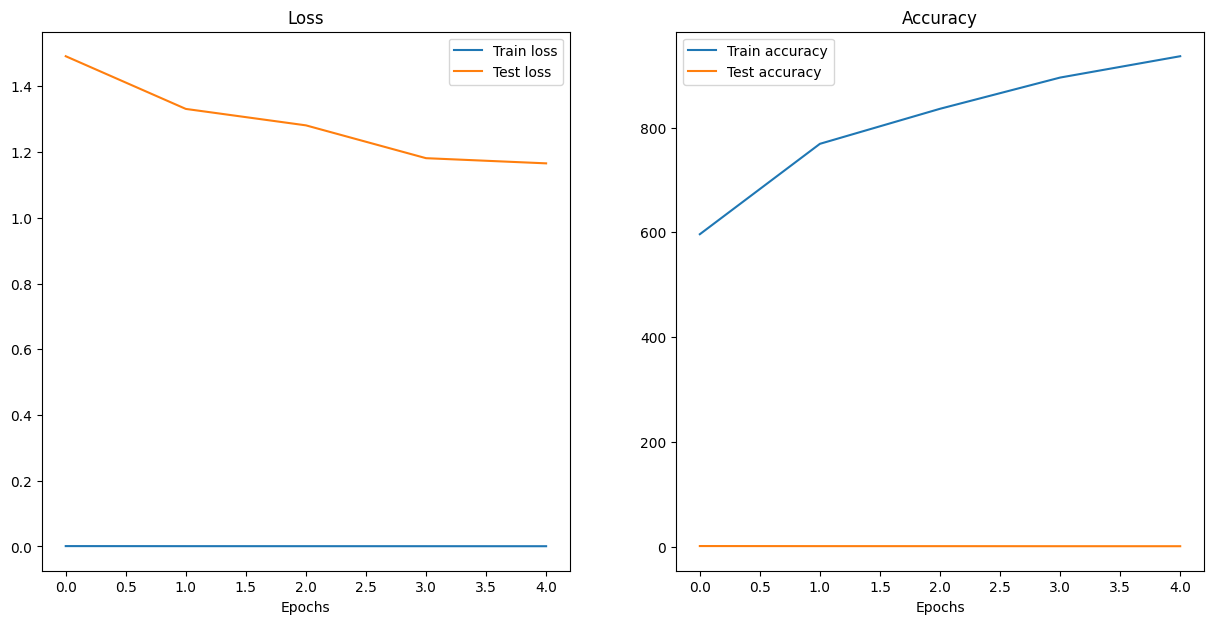

In [23]:
plot_loss_curves(train_result)

Text(0.5, 0, 'Epochs')

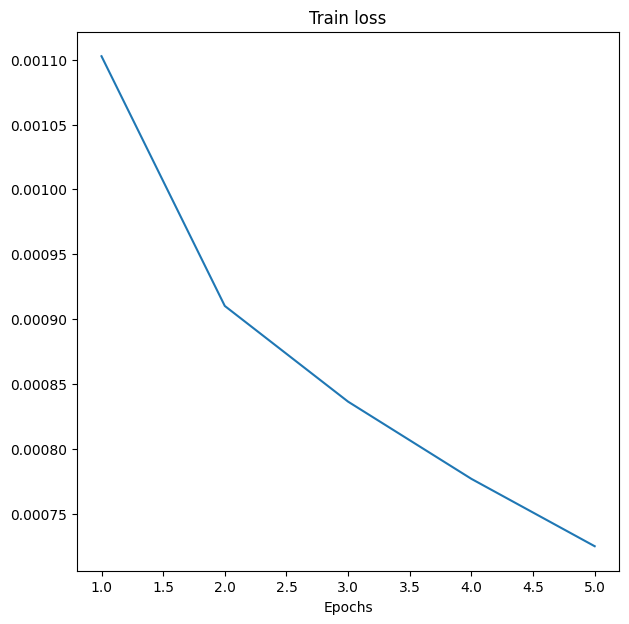

In [25]:
plt.figure(figsize=(7,7))
plt.plot(range(1, len(train_result["train_loss"]) + 1), train_result["train_loss"])
plt.title("Train loss")
plt.xlabel("Epochs")

In [76]:
from PIL import Image
import torch
import torch.nn.functional as F

# img_path = "bird.jpg"
img_path = "ship.jpg"

image = Image.open(img_path).convert("RGB")
image = train_transform(image)
image = image.unsqueeze(0)

image

tensor([[[[0.3608, 0.3608, 0.3608,  ..., 0.4196, 0.4157, 0.4157],
          [0.3608, 0.3608, 0.3647,  ..., 0.4235, 0.4196, 0.4196],
          [0.3647, 0.3647, 0.3647,  ..., 0.4235, 0.4235, 0.4235],
          ...,
          [0.2275, 0.2353, 0.2039,  ..., 0.2745, 0.3059, 0.3059],
          [0.2353, 0.2353, 0.2275,  ..., 0.2549, 0.2667, 0.2627],
          [0.2078, 0.2431, 0.2667,  ..., 0.2471, 0.2471, 0.2667]],

         [[0.5569, 0.5569, 0.5569,  ..., 0.5961, 0.5961, 0.6000],
          [0.5569, 0.5569, 0.5569,  ..., 0.6000, 0.6000, 0.6000],
          [0.5608, 0.5608, 0.5608,  ..., 0.6039, 0.6039, 0.6039],
          ...,
          [0.3725, 0.3804, 0.3451,  ..., 0.4078, 0.4353, 0.4353],
          [0.3804, 0.3843, 0.3725,  ..., 0.3882, 0.4000, 0.3882],
          [0.3529, 0.3922, 0.4157,  ..., 0.3804, 0.3804, 0.3961]],

         [[0.8471, 0.8471, 0.8471,  ..., 0.8353, 0.8314, 0.8353],
          [0.8471, 0.8471, 0.8471,  ..., 0.8353, 0.8353, 0.8392],
          [0.8471, 0.8471, 0.8471,  ..., 0

In [77]:
image = image.to(device)

with torch.no_grad():
  outputs = model_CNN(image)
  predicted_class = torch.argmax(outputs, dim=1).item()


Predicted class: Ship


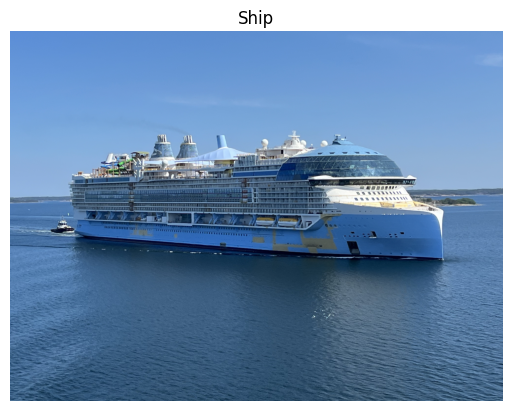

In [78]:

print(f"Predicted class: {classes[predicted_class]}")

plt.imshow(Image.open(img_path))
plt.title(classes[predicted_class])
plt.axis("off")
plt.show()